# Cyclic symmetry analysis

This notebook demonstrates how to use the Workbench client to manage projects on a remote host, run scripts, and handle output files.
It covers launching services, uploading files, executing scripts, and visualizing results using PyMechanical.

In [1]:
import os
import pathlib

In [2]:
from ansys.workbench.core import launch_workbench
from ansys.mechanical.core import connect_to_mechanical

Launch the Workbench service on a remote host machine, specifying the remote host machine name and user login credentials.
Define several directories that will be used during the session.
`workdir` is set to the parent directory of the current file.
`assets`, `scripts`, and `cdb` are subdirectories within the working directory.
The `launch_workbench` function is called to start a Workbench session with specified directory.

In [3]:
workdir = pathlib.Path("__file__").parent

In [4]:
assets = workdir / "assets"
scripts = workdir / "scripts"

In [5]:
wb = launch_workbench(client_workdir=str(workdir.absolute()))

Upload the project files to the server using the `upload_file_from_example_repo` method.
The file to upload is `sector_model.cdb`.

In [6]:
wb.upload_file_from_example_repo("cyclic-symmetry-analysis/cdb/sector_model.cdb")

Uploading sector_model.cdb:   0%|          | 0.00/7.86M [00:00<?, ?B/s]

Uploading sector_model.cdb: 100%|██████████| 7.86M/7.86M [00:00<00:00, 87.9MB/s]

Execute a Workbench script (`project.wbjn`) to define the project and load the geometry using the `run_script_file` method.
The `set_log_file` method is used to direct the logs to `wb_log_file.log`.
The name of the system created is stored in `sys_name` and printed.

In [7]:
export_path = 'wb_log_file.log'
wb.set_log_file(export_path)
sys_name = wb.run_script_file(str((assets / "project.wbjn").absolute()), log_level='info')
print(sys_name)

SYS 1


Start a PyMechanical server for the system using the `start_mechanical_server` method.
Create a PyMechanical client session connected to this server using `connect_to_mechanical`.
The project directory is printed to verify the connection.

In [8]:
server_port = wb.start_mechanical_server(system_name=sys_name)

In [9]:
mechanical = connect_to_mechanical(ip='localhost', port=server_port)

In [10]:
print(mechanical.project_directory)

C:\Users\ansys\AppData\Local\Temp\WB_ansys_19576_2\wbnew_files\


Read and execute the script `cyclic_symmetry_analysis.py` via the PyMechanical client using `run_python_script`.
This script typically contains commands to mesh and solve the model.
The output of the script is printed.

In [11]:
with open(scripts / "cyclic_symmetry_analysis.py") as sf:
    mech_script = sf.read()
mech_output = mechanical.run_python_script(mech_script)
print(mech_output)

{"Total Deformation": "5.202362674608513 [mm]", "Total Deformation 2": "2.182211520602412 [mm]"}


Specify the Mechanical directory and run a script to fetch the working directory path.
The path where all solver files are stored on the server is printed.
Download the solver output file (`solve.out`) from the server to the client's current working directory and print its contents.

In [12]:
mechanical.run_python_script(f"solve_dir=ExtAPI.DataModel.AnalysisList[5].WorkingDir")
result_solve_dir_server = mechanical.run_python_script(f"solve_dir")
print(f"All solver files are stored on the server at: {result_solve_dir_server}")

All solver files are stored on the server at: C:\Users\ansys\AppData\Local\Temp\WB_ansys_19576_2\wbnew_files\dp0\SYS-6\MECH\


In [13]:
solve_out_path = os.path.join(result_solve_dir_server, "solve.out")

In [14]:
def write_file_contents_to_console(path):
    """Write file contents to console."""
    with open(path, "rt") as file:
        for line in file:
            print(line, end="")

In [15]:
current_working_directory = os.getcwd()
mechanical.download(solve_out_path, target_dir=current_working_directory)
solve_out_local_path = os.path.join(current_working_directory, "solve.out")
write_file_contents_to_console(solve_out_local_path)
os.remove(solve_out_local_path)


 Ansys Mechanical Enterprise                       


 *------------------------------------------------------------------*
 |                                                                  |
 |   W E L C O M E   T O   T H E   A N S Y S (R)  P R O G R A M     |
 |                                                                  |
 *------------------------------------------------------------------*




 ***************************************************************
 *         ANSYS MAPDL 2024 R2          LEGAL NOTICES          *
 ***************************************************************
 *                                                             *
 * Copyright 1971-2024 Ansys, Inc.  All rights reserved.       *
 * Unauthorized use, distribution or duplication is            *
 * prohibited.                                                 *
 *                                                             *
 * Ansys is a registered trademark of Ansys, Inc. or its       *
 * sub

Specify the Mechanical directory path for images and run a script to fetch the directory path.
The path where images are stored on the server is printed.
Download an image file (`deformation.png`) from the server to the client's current working directory and display it using `matplotlib`.

In [16]:
from matplotlib import image as mpimg
from matplotlib import pyplot as plt

In [17]:
mechanical.run_python_script(f"image_dir=ExtAPI.DataModel.AnalysisList[5].WorkingDir")
result_image_dir_server = mechanical.run_python_script(f"image_dir")
print(f"Images are stored on the server at: {result_image_dir_server}")

Images are stored on the server at: C:\Users\ansys\AppData\Local\Temp\WB_ansys_19576_2\wbnew_files\dp0\SYS-6\MECH\


In [18]:
def get_image_path(image_name):
    return os.path.join(result_image_dir_server, image_name)

In [19]:
def display_image(path):
    print(f"Printing {path} using matplotlib")
    image1 = mpimg.imread(path)
    plt.figure(figsize=(15, 15))
    plt.axis("off")
    plt.imshow(image1)
    plt.show()

In [20]:
image_name = "deformation.png"
image_path_server = get_image_path(image_name)

Local image path : C:\Users\ansys\actions-runner\_work\pyworkbench-examples\pyworkbench-examples\pyworkbench-examples\doc\source\examples\cyclic-symmetry-analysis\deformation.png
Printing C:\Users\ansys\actions-runner\_work\pyworkbench-examples\pyworkbench-examples\pyworkbench-examples\doc\source\examples\cyclic-symmetry-analysis\deformation.png using matplotlib


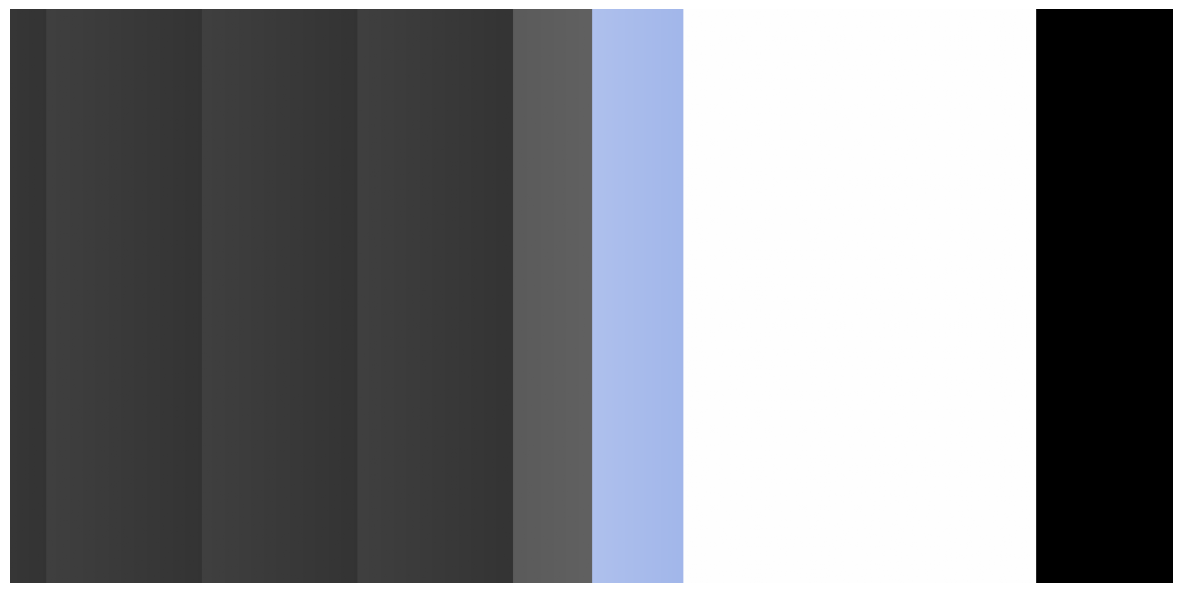

In [21]:
if image_path_server != "":
    current_working_directory = os.getcwd()

    local_file_path_list = mechanical.download(
        image_path_server, target_dir=current_working_directory
    )
    image_local_path = local_file_path_list[0]
    print(f"Local image path : {image_local_path}")

    display_image(image_local_path)

Download all the files from the server to the current working directory.
Verify the source path for the directory and copy all files from the server to the client.

In [22]:
mechanical.run_python_script(f"solve_dir=ExtAPI.DataModel.AnalysisList[5].WorkingDir")
result_solve_dir_server = mechanical.run_python_script(f"solve_dir")
print(f"All solver files are stored on the server at: {result_solve_dir_server}")

All solver files are stored on the server at: C:\Users\ansys\AppData\Local\Temp\WB_ansys_19576_2\wbnew_files\dp0\SYS-6\MECH\


In [23]:
solve_out_path = os.path.join(result_solve_dir_server, "*.*")

In [24]:
current_working_directory = os.getcwd()
mechanical.download(solve_out_path, target_dir=current_working_directory)

['C:\\Users\\ansys\\actions-runner\\_work\\pyworkbench-examples\\pyworkbench-examples\\pyworkbench-examples\\doc\\source\\examples\\cyclic-symmetry-analysis\\CAERep.xml',
 'C:\\Users\\ansys\\actions-runner\\_work\\pyworkbench-examples\\pyworkbench-examples\\pyworkbench-examples\\doc\\source\\examples\\cyclic-symmetry-analysis\\CAERepOutput.xml',
 'C:\\Users\\ansys\\actions-runner\\_work\\pyworkbench-examples\\pyworkbench-examples\\pyworkbench-examples\\doc\\source\\examples\\cyclic-symmetry-analysis\\cyclic_map.json',
 'C:\\Users\\ansys\\actions-runner\\_work\\pyworkbench-examples\\pyworkbench-examples\\pyworkbench-examples\\doc\\source\\examples\\cyclic-symmetry-analysis\\deformation.png',
 'C:\\Users\\ansys\\actions-runner\\_work\\pyworkbench-examples\\pyworkbench-examples\\pyworkbench-examples\\doc\\source\\examples\\cyclic-symmetry-analysis\\ds.dat',
 'C:\\Users\\ansys\\actions-runner\\_work\\pyworkbench-examples\\pyworkbench-examples\\pyworkbench-examples\\doc\\source\\examples\\c

Finally, the `exit` method is called on both the PyMechanical and Workbench clients to gracefully shut down the services, ensuring that all resources are properly released.

In [25]:
mechanical.exit()
wb.exit()